# DeepONet Operator for the Burgers' Equation

### Introduction

In this notebook, we explore the application of DeepONet to the well-known 1-dimensional Burgers' equation. The Burgers' equation is a non-linear partial differential equation (PDE) with applications in modeling one-dimensional flow of viscous fluid. The equation is given by:

$$ \partial_tu(x, t) + \partial_x(u^2(x, t)/2) = \nu\partial_{xx}u(x, t)$$
where $x \in (0, 1)$, $t \in (0, 1)$ and $u(x, 0) = u_0(x)$ as the initial condition. 

The equation exhibits properties like shock waves and has been a model of interest in fluid dynamics and turbulence.

### Objective

Given the initial condition $u_0 \in L^2((0, 1); \mathbb{R})$ and the viscosity coefficient $\nu$, our aim is to leverage the capabilities of the Fourier Neural Operator to learn the operator mapping the initial condition to its solution at any time $t$. In other words, we're interested in predicting the solution of the Burgers' equation for different initial conditions using deep learning.

### Approach

1. **Data Preparation**: We'll be using the dataset 'burgers_data_R10.mat', which provides us with different initial conditions and their respective solutions.
2. **Model**: DeepONet will serve as our model, which utilizes the Fourier transform to operate in the frequency domain, providing both computational efficiency and accuracy.
3. **Training and Evaluation**: We will train our DeepONet model on the dataset and evaluate its performance against ground truth solutions.

By the end of this notebook, we aim to have a trained DeepONet model that can predict the Burgers' equation solution with high accuracy.

Let's dive in!

In [1]:
import torch
import gdown
import os
import scipy
import matplotlib.pyplot as plt
import numpy as np
import h5py
from functools import reduce
import operator

output = 'burgers_data_R10.mat'  # Change the extension to .zip (or whatever the actual extension is)

# Only download if the file doesn't exist
if not os.path.exists(output):
    url = 'https://drive.google.com/uc?export=download&id=1UsGPoCe8vXbLtD8tS2Azr88s8s-ZFJwr'
    gdown.download(url, output, quiet=False)
else:
    print(f"{output} already exists, skipping download.")

burgers_data_R10.mat already exists, skipping download.


### Burger's Equation Dataset

Recall the 1-d Burger's equation on the unit torus:
$$ \frac{\partial u(x, t)}{\partial t} + \frac{\partial (u^2(x, t)/2)}{\partial x} = \nu \frac{\partial^2 u(x, t)}{\partial x^2}, \quad x \in (0, 1), t \in (0, 1) $$
with the initial condition:
$$ u(x, 0) = u_0(x),  x \in (0, 1). $$

The initial condition $ u_0(x) $ is generated according to $ u_0 \sim \mu $ where $ \mu = N(0, 625 - \Delta + 25I)^{-2} $ with periodic boundary conditions. We set the viscosity to $ \nu = 0.1 $ and solve the equation using a split step method where the heat equation part is solved exactly in Fourier space then the non-linear part is advanced, again in Fourier space, using a very fine forward Euler method. We solve on a spatial mesh with resolution $ 2^{13} = 8192 $ and use this dataset to subsample other resolutions.

## Data Visualization

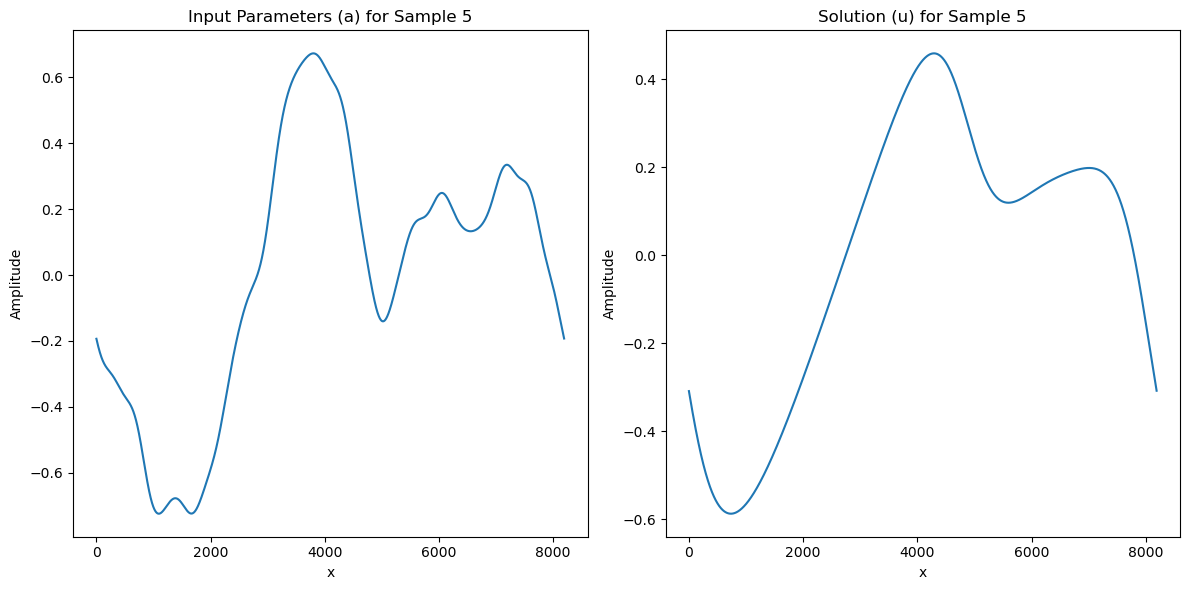

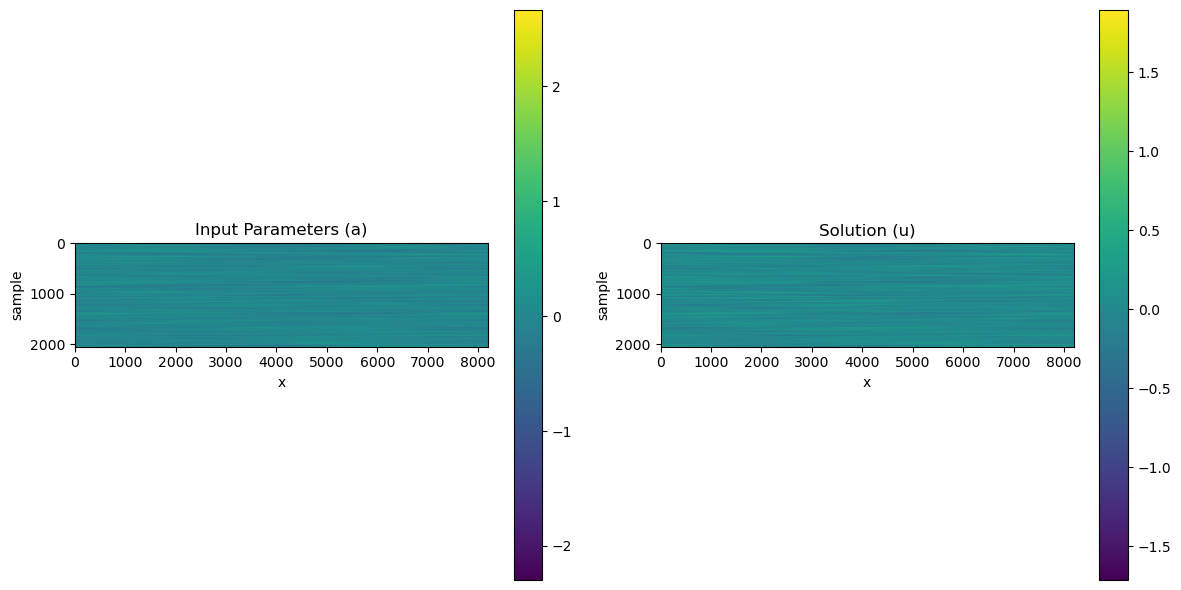

In [27]:
# Load the data
data = scipy.io.loadmat('burgers_data_R10.mat')


# Choose a specific sample index
sample_index = 5

# Extract the specific sample from data
input_sample = data['a'][sample_index]
solution_sample = data['u'][sample_index]

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the input sample
ax1.plot(input_sample)
ax1.set_title(f'Input Parameters (a) for Sample {sample_index}')
ax1.set_xlabel('x')
ax1.set_ylabel('Amplitude')

# Plot the solution sample
ax2.plot(solution_sample)
ax2.set_title(f'Solution (u) for Sample {sample_index}')
ax2.set_xlabel('x')
ax2.set_ylabel('Amplitude')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 'a' - the input parameters
cax1 = ax1.imshow(data['a'])
ax1.set_title('Input Parameters (a)')
ax1.set_xlabel('x')
ax1.set_ylabel('sample')
fig.colorbar(cax1, ax=ax1)

# Plot 'u' - the solution
cax2 = ax2.imshow(data['u'])
ax2.set_title('Solution (u)')
ax2.set_xlabel('x')
ax2.set_ylabel('sample')
fig.colorbar(cax2, ax=ax2)

# Adjust layout
plt.tight_layout()
plt.show()


## Pytorch Implementation

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA.")

# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using MPS.")

else:
    device = torch.device("cpu")
    print("Using CPU.")

Using CPU.


In [5]:
class MatReader:
    def __init__(self, file_path, to_float=True):
        """
        Initialize a MatReader object.
        
        :param file_path: Path to the .mat file.
        :param to_float: Convert data to float type.
        """
        self.to_float = to_float

        self.data = self._load_file(file_path)

    def _load_file(self, file_path):
        """
        Load the .mat file.
        
        :param file_path: Path to the .mat file.
        """
        try:
            data = scipy.io.loadmat(file_path)
            old_mat = True
        except NotImplementedError:
            data = h5py.File(file_path, 'r')
            old_mat = False

        return {'data': data, 'old_mat': old_mat}

    def read_field(self, field):
        """
        Read the specified field from the .mat file.
        
        :param field: Name of the field to read.
        """
        x = self.data['data'][field]

        if not self.data['old_mat']:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        # Always convert to PyTorch tensor
        x = torch.from_numpy(x).to(device)

        return x

    def set_float(self, to_float):
        """Set the to_float flag."""
        self.to_float = to_float


## DeepONet: An Overview

DeepONet is a neural network designed to learn operators, transforming an input function to an output function. The fundamental idea behind DeepONet is to leverage two separate sub-networks, namely the "branch" and the "trunk" networks.

### Diagram
```
                           +---------+
                           | Branch  |
          +--------+       |  Net    |
          |  v(x_1) |------>|         |
          |   .    |       |         |
          |   .    |       |         |
          | v(x_m)  |       |         |
          +--------+       |         |
                           +----+----+
                                |
                                | b
                           +----v----+
                           |         |
          +--------+       |  Dot    |------> G(v)(y)
          |   y    |------>| Product |
          +--------+       |         |
                           +----+----+
                                |
                           +----v----+
                           |  Trunk  |
                           |   Net   |
                           |         |
                           +---------+

```

### Discretizing the Input Function

A primary challenge in working with input functions is the need for discretization. For numerical operations, the function must be represented in a finite-dimensional space. DeepONet achieves this by evaluating the function at a set of locations, such as:

$$ v = [v(x_1), v(x_2), ... , v(x_m)] $$

There are various other approaches to represent this discretized function, including basis function projections. However, DeepONet's choice of function evaluations offers simplicity and versatility.

### Network Architecture

#### **1. Trunk Network**:
- **Input**: Coordinates $ \xi $ from domain $ D' $.
- **Functionality**: Often a simpler network since $ \xi $ is typically low-dimensional.
- **Output**: Produces outputs { $ t_1, t_2, ... , t_p $ }.

#### **2. Branch Network**:
- **Input**: Discretized function $ v $.
- **Functionality**: Can vary based on the structure of $ v $. Possible architectures include FNN, ResNet, CNN, RNN, or GNN.
- **Output**: Produces outputs { $ b_1, b_2, ... , b_p $ }.

The final output from DeepONet is expressed as:

$$ G(v)(\xi) = \sum_{k=1}^{p} b_k(v) \times t_k(\xi) + b_0 $$

Where $ b_0 $ is a bias term.

### Flexibility of DeepONet

DeepONet offers a high-level framework, which means the trunk and branch networks aren't restricted to specific architectures. The choice of architecture for the branch network particularly depends on the nature of the discretized input function $ v $.

For instance, if $ v $ is discretized on a 2D equispaced grid, a CNN might be suitable. In contrast, if the discretization occurs on an unstructured mesh, a GNN might be more apt.

In [30]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from torch import nn


class FNN(nn.Module):
    """Fully-connected neural network."""

    def __init__(self, layer_sizes):
        super(FNN, self).__init__()

        layers = []
        for i in range(1, len(layer_sizes) - 1):
            layers.append(
                nn.Linear(in_features=layer_sizes[i - 1], out_features=layer_sizes[i])
            )
            layers.append(nn.ReLU())
        layers.append(
            nn.Linear(in_features=layer_sizes[-2], out_features=layer_sizes[-1])
        )
        self.denses = nn.ModuleList(layers)

    def forward(self, inputs):
        y = inputs
        for f in self.denses:
            y = f(y)
        return y


class DeepONet(nn.Module):
    # Initialize the class
    def __init__(self, layer_size_branch, layer_size_trunk):
        super(DeepONet, self).__init__()

        # initialize parameters and configuration
        self.layer_size_branch = layer_size_branch
        self.layer_size_trunk = layer_size_trunk

        # initialize layers
        self.branch_net = FNN(self.layer_size_branch)
        if callable(self.layer_size_trunk[1]):
            # User-defined trunk net
            self.trunk_net = self.layer_size_trunk[1]
        else:
            self.trunk_net = FNN(self.layer_size_trunk)
        self.bias_last = torch.nn.Parameter(torch.tensor(0.0))


    def forward(self, x):
        # Extract x_branch and x_trunk from the input tensor
        x_branch, x_trunk = x
        
        # Branch net to encode the input function
        y_branch = self.branch_net(x_branch)
        # Trunk net to encode the domain of the output function
        y_trunk = self.trunk_net(x_trunk)
        # print(y_branch.shape, y_trunk.shape) # torch.Size([512, 128]) torch.Size([256, 128])
        
        # Dot product
        if y_branch.shape[-1] != y_trunk.shape[-1]:
            raise AssertionError(
                "Output sizes of branch net and trunk net do not match."
            )
        # print(y_branch.shape, y_trunk.shape)
        Y = torch.einsum('kj,ij->ik', y_trunk, y_branch)
        
        # Add bias 
        Y += self.bias_last.unsqueeze(0)
        return Y


def count_parameters(model):
    """
    Count the total number of trainable parameters in the model.
    
    Args:
    - model (nn.Module): PyTorch model.
    
    Returns:
    - int: Total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [31]:
CONFIG = {
    'ntrain': 1000,
    'ntest': 200,
    'original_grid_size': 2**13,
    'trunk_net_grid_size': 2**8,
    'branch_net_grid_size': 2**7,
    'batch_size': 512,
    'learning_rate': 0.001,
    'epochs': 5000,
    'step_size': 100,
    'gamma': 0.5,
    'modes': 8,
    'width': 128,
    'file_name': 'burgers_data_R10.mat',
}


sub_trunk = CONFIG['original_grid_size'] // CONFIG['trunk_net_grid_size']
sub_branch = CONFIG['original_grid_size'] // CONFIG['branch_net_grid_size']

dataloader = MatReader(CONFIG['file_name'])
x_data = dataloader.read_field('a')[:, ::sub_branch]
y_data = dataloader.read_field('u')[:, ::sub_trunk]
y_grid = torch.linspace(0, 1, CONFIG['trunk_net_grid_size']).reshape(-1, 1).to(device)

x_train = x_data[:CONFIG['ntrain'], :]
y_train = y_data[:CONFIG['ntrain'], :]
x_test = x_data[-CONFIG['ntest']:, :]
y_test = y_data[-CONFIG['ntest']:, :]

# Ensure x_train and y_grid are on the same device. Let's assume both should be on 'device'.
x_train = x_train.to(device)
y_grid = y_grid.to(device)

# Define your DataLoader 
from torch.utils.data import TensorDataset, DataLoader

# Create a dataset using x_train and y_train
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader for the training dataset
train_loader = DataLoader(dataset=train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)


In [33]:
# Define a training function
def train(model, train_loader, optimizer, loss_fn, y_grid):
    model.train()
    total_loss = 0.0

    for batch_x, batch_y in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        inputs = (batch_x, y_grid)
        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = loss_fn(outputs, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    return avg_loss

# Define an evaluation function
def evaluate(model, test_loader, loss_fn, y_grid):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            inputs = (batch_x, y_grid)
            outputs = model(inputs)
            outputs = outputs.squeeze(-1)
            loss = loss_fn(outputs, batch_y)

            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    return avg_loss

# Training the model
model = DeepONet(layer_size_branch=[128,256,256, 256], layer_size_trunk=[1, 64,256])
print(f"Number of parameters: {count_parameters(model)}")
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
loss_fn = nn.MSELoss()  # Mean Squared Error Loss

print("Starting training...")
for epoch in range(CONFIG['epochs']):
    train_loss = train(model, train_loader, optimizer, loss_fn, y_grid)
    test_loss = evaluate(model, test_loader, loss_fn, y_grid)
    
    print(f"Epoch {epoch + 1}/{CONFIG['epochs']}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

print("Training complete!")

Number of parameters: 181377
Starting training...
Epoch 1/5000, Train Loss: 1.1435, Test Loss: 0.5629, Learning Rate: 0.001000
Epoch 2/5000, Train Loss: 0.6299, Test Loss: 0.4956, Learning Rate: 0.001000
Epoch 3/5000, Train Loss: 0.4029, Test Loss: 0.2651, Learning Rate: 0.001000
Epoch 4/5000, Train Loss: 0.2718, Test Loss: 0.3103, Learning Rate: 0.001000
Epoch 5/5000, Train Loss: 0.3113, Test Loss: 0.2754, Learning Rate: 0.001000
Epoch 6/5000, Train Loss: 0.2578, Test Loss: 0.2215, Learning Rate: 0.001000
Epoch 7/5000, Train Loss: 0.2092, Test Loss: 0.2090, Learning Rate: 0.001000
Epoch 8/5000, Train Loss: 0.2051, Test Loss: 0.2170, Learning Rate: 0.001000
Epoch 9/5000, Train Loss: 0.2124, Test Loss: 0.2128, Learning Rate: 0.001000
Epoch 10/5000, Train Loss: 0.2045, Test Loss: 0.2002, Learning Rate: 0.001000
Epoch 11/5000, Train Loss: 0.1910, Test Loss: 0.1931, Learning Rate: 0.001000
Epoch 12/5000, Train Loss: 0.1839, Test Loss: 0.1899, Learning Rate: 0.001000
Epoch 13/5000, Train Lo

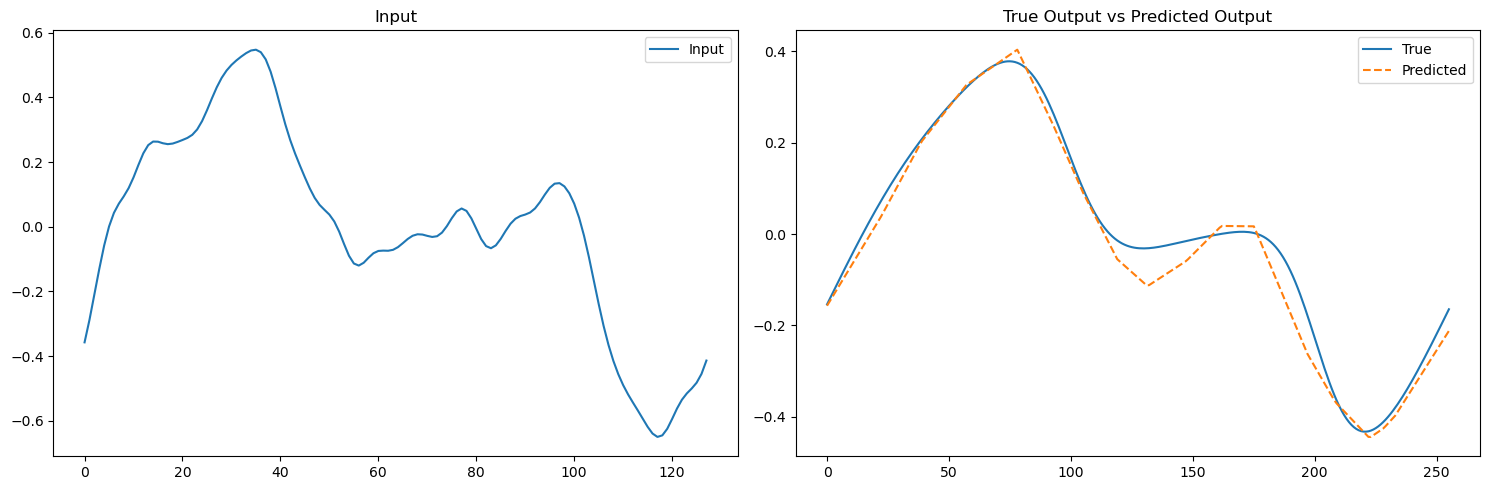

: 

In [34]:
def plot_results(input_data, true_output, predicted_output, sample_idx):
    """Plot the input data, true output and the predicted output for a given sample index."""
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Input data plot
    ax[0].plot(input_data[sample_idx].cpu().numpy(), label='Input')
    ax[0].set_title('Input')
    ax[0].legend()

    # True vs. Predicted output plot
    ax[1].plot(true_output[sample_idx].cpu().numpy(), label='True')
    ax[1].plot(predicted_output[sample_idx].cpu().numpy(), linestyle='dashed', label='Predicted')
    ax[1].set_title('True Output vs Predicted Output')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Fetch the first batch of test data
x_test_batch, y_test_batch = next(iter(test_loader))

# Set the model to evaluation mode
model.eval()

# Predict using the model without computing gradients
with torch.no_grad():
    inputs = (x_test_batch, y_grid)
    predicted_outputs = model(inputs)

# Index of the sample you want to visualize
sample_index = 30

# Call the plotting function
plot_results(x_test_batch, y_test_batch, predicted_outputs, sample_index)
